# Cooperative Classifying Neural Cellular Automata

This notebook is dedicated to experimenting with cooperating NCAs for better out-of-distribution classification.

Explicitly, I'd like to extend a trained model on MNIST to the classification of different natural numbers > 9!

For simplicity and time constraints, I'll only work with the first 3 classes (i.e. 0, 1, 2), but the results should be easily generalisable to the rest of the digits.

Why not use pretrained models? The ones [provided](https://github.com/google-research/self-organising-systems/blob/master/assets/mnist_ca/models.zip) are quite bad (barely trained at all, in fact!)

In [23]:
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import json
import math
import numpy as np
import matplotlib.pylab as pl
import glob

import tensorflow as tf
from tensorflow.keras.layers import Conv2D

from google.protobuf.json_format import MessageToDict
from tensorflow.python.framework import convert_to_constants

from IPython.display import Image, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

clear_output()

In [24]:
def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    if len(img.shape) == 3 and img.shape[-1] == 4:
      img = img[..., :3] * img[..., 3, None]
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.array(x_train / 255.0,).astype(np.float32)
x_test = np.array(x_test / 255.0,).astype(np.float32)

In [30]:
# turn the problem into a binary classification one for simplicity
mask_train = (y_train == 0) | (y_train == 1) | (y_train == 2)
mask_test = (y_test == 0) | (y_test == 1) | (y_test == 2)

x_train = x_train[mask_train]
y_train = y_train[mask_train]
x_test = x_test[mask_test]
y_test = y_test[mask_test]

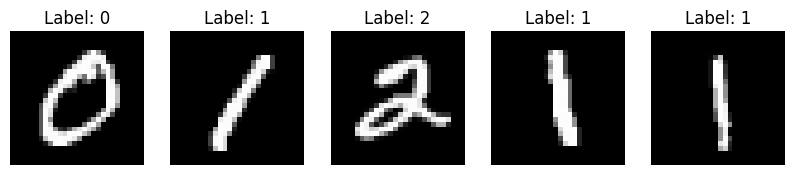

(18623, 3147, array([0, 1, 2], dtype=uint8), array([0, 1, 2], dtype=uint8))

In [31]:
# let's see if everything is as expected...
fig, axes = pl.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')

pl.show()

num_train_samples = x_train.shape[0]
num_test_samples = x_test.shape[0]
unique_train_labels = np.unique(y_train)
unique_test_labels = np.unique(y_test)

num_train_samples, num_test_samples, unique_train_labels, unique_test_labels

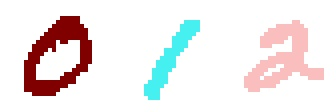

Storing x_legend for use in the demo.


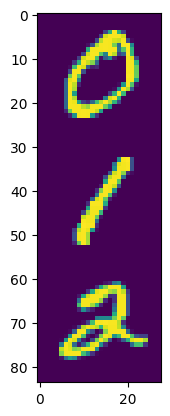

In [36]:
color_lookup = tf.constant([
            [128, 0, 0],
            [70, 240, 240],
            [250, 190, 190],
            
            [0, 0, 0], # default for digits.
            [255, 255, 255] # This is the background.
            ])
backgroundWhite = True

def color_labels(x, y_pic, disable_black=False, dtype=tf.uint8):
  # works for shapes of x [b, r, c] and [r, c]
  black_and_white = tf.fill(list(x.shape) + [2], 0.01)
  is_gray = tf.cast(x > 0.1, tf.float32)
  is_not_gray = 1. - is_gray

  y_pic = y_pic * tf.expand_dims(is_gray, -1) # forcibly cancels everything outside of it.
  
  # if disable_black, make is_gray super low.
  if disable_black:
    is_gray *= -1e5
    # this ensures that you don't draw white in the digits.
    is_not_gray += is_gray

  bnw_order = [is_gray, is_not_gray] if backgroundWhite else [is_not_gray, is_gray]
  black_and_white *= tf.stack(bnw_order, -1)

  rgb = tf.gather(
      color_lookup,
      tf.argmax(tf.concat([y_pic, black_and_white], -1), -1))
  if dtype == tf.uint8:
    return tf.cast(rgb, tf.uint8)
  else:
    return tf.cast(rgb, dtype) / 255.

def to_two_dim_label(x, y):
  # x shape is [b, r, c]
  # y shape is [b]

  # y_res shape is [b, r, c, 2]
  y_res = np.zeros(list(x.shape) + [3])
  # broadcast y to match x shape:
  y_expanded = np.broadcast_to(y, x.T.shape).T
  y_res[x >= 0.1, y_expanded[x >= 0.1]] = 1.0
  return y_res.astype(np.float32)

def find_different_numbers(x_set, y_set, y_set_pic, orientation="vertical"):
  result_y = []
  result_x = []
  for i in range(3):
    for x, y, y_pic in zip(x_set, y_set, y_set_pic):
      if y == i:
        result_y.append(color_labels(x, y_pic))
        result_x.append(x)
        break
  assert len(result_y) == 3

  result_y = np.concatenate(result_y, axis=0 if orientation == "vertical" else 1)
  result_x = np.stack(result_x)

  return result_y, result_x

y_train_pic = to_two_dim_label(x_train, y_train)
y_test_pic = to_two_dim_label(x_test, y_test)

numbers_legend, x_legend = find_different_numbers(x_train, y_train, y_train_pic)
numbers_legend_horiz, _ = find_different_numbers(x_train, y_train, y_train_pic, "horizontal")

imshow(zoom(numbers_legend_horiz))

print("Storing x_legend for use in the demo.")
pl.imshow(x_legend.reshape((-1, 28)))
samples_str = json.dumps(x_legend.tolist())

## Cellular Automata parameters

In [37]:
CHANNEL_N = 11 # CA state channels
BATCH_SIZE = 16
POOL_SIZE = BATCH_SIZE * 10
CELL_FIRE_RATE = 0.5

MODEL_TYPE = '2 persistent'  # ['1 naive', '2 persistent', '3 mutating']
ADD_NOISE = True

USE_PATTERN_POOL, MUTATE_POOL = {
    '1 naive': (False, False),
    '2 persistent': (True, False),
    '3 mutating': (True, True)
    }[MODEL_TYPE]

In [48]:
class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE,
               add_noise=ADD_NOISE):
    # CHANNEL_N does NOT include the greyscale channel.
    # but it does include the 2 possible outputs.
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate
    self.add_noise = add_noise

    self.perceive = tf.keras.Sequential([
          Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"),
      ])

    self.dmodel = tf.keras.Sequential([
          Conv2D(80, 1, activation=tf.nn.relu),
          Conv2D(self.channel_n, 1, activation=None,
                       kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n + 1]))  # dummy calls to build the model

  @tf.function
  def call(self, x, fire_rate=None, manual_noise=None):
    gray, state = tf.split(x, [1, self.channel_n], -1)
    ds = self.dmodel(self.perceive(x))

    if self.add_noise:
      if manual_noise is None:
        residual_noise = tf.random.normal(tf.shape(ds), 0., 0.02)
      else:
        residual_noise = manual_noise
      ds += residual_noise

    if fire_rate is None:
      fire_rate = self.fire_rate

    update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
    living_mask = gray > 0.1
    residual_mask = update_mask & living_mask

    ds *= tf.cast(residual_mask, tf.float32)
    state += ds
    
    return tf.concat([gray, state], -1)

  @tf.function
  def initialize(self, images):
    state = tf.zeros([tf.shape(images)[0], 28, 28, self.channel_n])
    images = tf.reshape(images, [-1, 28, 28, 1])
    return tf.concat([images, state], -1)

  @tf.function
  def classify(self, x):
    # the last 2 layers are the classification predictions, one channel
    # per class. Keep in mind there is no "background" class,
    # and that any loss doesn't propagate to "dead" pixels.
    return x[:,:,:,-3:]

In [49]:
CAModel().perceive.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (1, 3, 3, 80)             8720      
                                                                 
Total params: 8720 (34.06 KB)
Trainable params: 8720 (34.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-24 16:16:29.364348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [50]:
CAModel().dmodel.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (1, 3, 3, 80)             6480      
                                                                 
 conv2d_35 (Conv2D)          (1, 3, 3, 11)             891       
                                                                 
Total params: 7371 (28.79 KB)
Trainable params: 7371 (28.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-08-24 16:16:29.906410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


# Training and visualization utils

In [41]:
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None 
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

In [42]:
def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N+1]),
      fire_rate=tf.constant(0.5),
      manual_noise=tf.TensorSpec([None, None, None, CHANNEL_N]))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

In [51]:
def classify_and_color(ca, x, disable_black=False):
  return color_labels(
      x[:,:,:,0], ca.classify(x), disable_black, dtype=tf.float32)

def generate_tiled_figures(figures, fade_by=0.1):
  tiled_pool = tile2d(figures)
  fade_sz = int(tiled_pool.shape[0] * fade_by)
  fade = np.linspace(1.0, 0.0, fade_sz)
  ones = np.ones(fade_sz) 
  tiled_pool[:, :fade_sz] += (-tiled_pool[:, :fade_sz] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -fade_sz:] += (-tiled_pool[:, -fade_sz:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:fade_sz, :] += (-tiled_pool[:fade_sz, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-fade_sz:, :] += (-tiled_pool[-fade_sz:, :] + ones[:, None, None]) * fade[::-1, None, None]
  return tiled_pool

def generate_pool_figures(ca, pool, step_i):
  tiled_pool = tile2d(classify_and_color(ca, pool.x))
  fade = np.linspace(1.0, 0.0, 72)
  ones = np.ones(72) 
  tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
  tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
  tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
  tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
  imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(ca, x0, x, step_i):
  vis0 = np.hstack(classify_and_color(ca, x0).numpy())
  vis1 = np.hstack(classify_and_color(ca, x).numpy())
  vis = np.vstack([vis0, vis1])
  imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)

def plot_loss(loss_log):
  pl.figure(figsize=(10, 4))
  pl.title('Loss history (log10)')
  pl.plot(np.log10(loss_log), '.', alpha=0.5)
  pl.show()

# Training

In [52]:
def individual_l2_loss(ca, x, y):
  t = y - ca.classify(x)
  return tf.reduce_sum(t**2, [1, 2, 3]) / 2

def batch_l2_loss(ca, x, y):
  return tf.reduce_mean(individual_l2_loss(ca, x, y))

In [53]:
# Initialize things for a new training run
ca = CAModel()

loss_log = []

lr = 1e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
      [3000, 7000], [lr, lr*0.1, lr*0.01])
trainer = tf.keras.optimizers.legacy.Adam(lr_sched)

starting_indexes = np.random.randint(0, x_train.shape[0]-1, size=POOL_SIZE)
pool = SamplePool(x=ca.initialize(x_train[starting_indexes]).numpy(), y=y_train_pic[starting_indexes])

2023-08-24 16:17:22.799512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-24 16:17:22.855295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [54]:
!mkdir -p train_log && rm -f train_log/*

zsh:1: no matches found: train_log/*


batch (before/after):


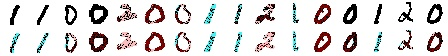

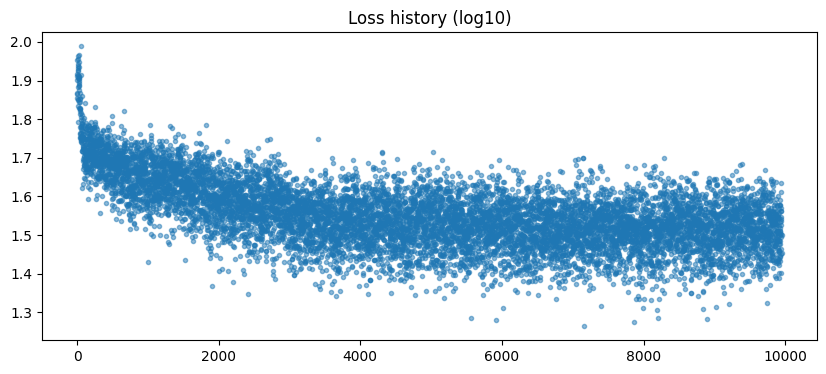

 step: 10000, log10(loss): 1.521

In [55]:
@tf.function
def train_step(x, y):
  iter_n = 20
  with tf.GradientTape() as g:
    for i in tf.range(iter_n):
      x = ca(x)
    loss = batch_l2_loss(ca, x, y)
  grads = g.gradient(loss, ca.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  trainer.apply_gradients(zip(grads, ca.weights))
  return x, loss

for i in range(1, 10_000+1):
  if USE_PATTERN_POOL:
    batch = pool.sample(BATCH_SIZE)
    x0 = np.copy(batch.x)
    y0 = batch.y
    # we want half of them new. We remove 1/4 from the top and 1/4 from the
    # bottom.
    q_bs = BATCH_SIZE // 4

    new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
    x0[:q_bs] = ca.initialize(x_train[new_idx])
    y0[:q_bs] = y_train_pic[new_idx]

    new_idx = np.random.randint(0, x_train.shape[0]-1, size=q_bs)
    new_x, new_y = x_train[new_idx], y_train_pic[new_idx]

    if MUTATE_POOL:
      new_x = tf.reshape(new_x, [q_bs, 28, 28, 1])
      mutate_mask = tf.cast(new_x > 0.1, tf.float32)
      mutated_x = tf.concat([new_x, x0[-q_bs:,:,:,1:] * mutate_mask], -1)

      x0[-q_bs:] = mutated_x
      y0[-q_bs:] = new_y

    else:
      x0[-q_bs:] = ca.initialize(new_x)
      y0[-q_bs:] = new_y

  else:
    b_idx = np.random.randint(0, x_train.shape[0]-1, size=BATCH_SIZE)
    x0 = ca.initialize(x_train[b_idx])
    y0 = y_train_pic[b_idx]

  x, loss = train_step(x0, y0)

  if USE_PATTERN_POOL:
    batch.x[:] = x
    batch.y[:] = y0 # This gets reordered, so you need to change it.
    batch.commit()

  step_i = len(loss_log)
  loss_log.append(loss.numpy())

  if step_i % 50 == 0:
    generate_pool_figures(ca, pool, step_i)
  if step_i % 50 == 0:
    clear_output()
    visualize_batch(ca, x0, x, step_i)
    plot_loss(loss_log)
  if step_i % 100 == 0:
    export_model(ca, 'train_log/%07d'%step_i)

  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')

In [ ]:
# # useful code if you end up interrupting the run.
# print(step_i)
# export_model(ca, 'train_log/%07d'%step_i)

In [57]:
# training progress (batches)
frames = sorted(glob.glob('train_log/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('classifying_batches_mnist.mp4')
mvp.ipython_display('classifying_batches_mnist.mp4')

Moviepy - Building video classifying_batches_mnist.mp4.
Moviepy - Writing video classifying_batches_mnist.mp4



Moviepy - Done !
Moviepy - video ready classifying_batches_mnist.mp4


In [58]:
# pool contents
frames = sorted(glob.glob('train_log/*_pool.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('classifying_pool_mnist.mp4')
mvp.ipython_display('classifying_pool_mnist.mp4')

Moviepy - Building video classifying_pool_mnist.mp4.
Moviepy - Writing video classifying_pool_mnist.mp4



Moviepy - Done !
Moviepy - video ready classifying_pool_mnist.mp4


## Evaluation

In [59]:
def eval_perform_steps(ca, x, yt, num_steps):
  yt_label = tf.argmax(yt, axis=-1)

  live_mask = x[..., 0] > 0.1
  live_mask_fl = tf.expand_dims(tf.cast(live_mask, tf.float32), -1)
  dead_channel = tf.cast(x[..., :1] <= 0.1, tf.float32)

  # for now the metric is aggregating everything.
  total_count = tf.reduce_sum(tf.cast(live_mask, tf.float32))

  avg_accuracy_list = []
  avg_total_agreement_list = []
  for _ in range(1, num_steps + 1):
    x = ca(x)

    y = ca.classify(x)
    y_label = tf.argmax(y, axis=-1)

    correct = tf.equal(y_label,  yt_label) & live_mask
    total_correct = tf.reduce_sum(tf.cast(correct, tf.float32))
    avg_accuracy_list.append((total_correct/total_count * 100).numpy().item())

    # agreement metrics
    # Important to exclude dead cells:
    y = y * live_mask_fl
    y_label_plus_mask = tf.argmax(tf.concat([y, dead_channel], -1), axis=-1)
    all_counts = []
    for idx in range(2):
      count_i = tf.reduce_sum(
          tf.cast(tf.equal(y_label_plus_mask, idx), tf.int32), axis=[1,2])
      all_counts.append(count_i)
    all_counts_t = tf.stack(all_counts, 1)
    # Now the trick is that if there is a total agreement, their sum is the same
    # as their max.
    equality = tf.equal(tf.reduce_max(all_counts_t, axis=1),
                        tf.reduce_sum(all_counts_t, axis=1))
    sum_agreement = tf.reduce_sum(tf.cast(equality, tf.float32))
    avg_total_agreement_list.append(sum_agreement.numpy().item() / y.shape[0] * 100)

  return avg_accuracy_list, avg_total_agreement_list

def eval_batch_fn(ca, x_test, y_test_pic, num_steps, mutate):
  x = ca.initialize(x_test)
  yt = y_test_pic

  avg_acc_l_1, avg_tot_agr_l_1 = eval_perform_steps(ca, x, yt, num_steps)
  if not mutate:
    return avg_acc_l_1, avg_tot_agr_l_1
  # Accuracy after mutation!
  new_idx = np.random.randint(0, x_test.shape[0]-1, size=x_test.shape[0])
  new_x, yt = x_test[new_idx], y_test_pic[new_idx]
  new_x = tf.reshape(new_x, [-1, 28, 28, 1])
  mutate_mask = tf.cast(new_x > 0.1, tf.float32)

  x = tf.concat([new_x, x[:,:,:,1:] * mutate_mask], -1)

  avg_acc_l_2, avg_tot_agr_l_2 = eval_perform_steps(ca, x, yt, num_steps)

  return avg_acc_l_1 + avg_acc_l_2, avg_tot_agr_l_1 + avg_tot_agr_l_2

def eval_all(ca, num_steps, mutate):
  all_accuracies = []
  all_agreements = []

  # total test set is 2115 (check a few cells above)
  num_batches = 10
  eval_bs = 2115 // num_batches
  for i in tqdm.trange(num_batches):
    x_set = x_test[eval_bs*i:eval_bs*(i+1)]
    y_set = y_test_pic[eval_bs*i:eval_bs*(i+1)]
    acc_i, agr_i = eval_batch_fn(ca, x_set, y_set, num_steps, mutate)
    all_accuracies.append(acc_i)
    all_agreements.append(agr_i)

  all_accuracies = [sum(l)/num_batches for l in zip(*all_accuracies)]
  all_agreements = [sum(l)/num_batches for l in zip(*all_agreements)]
  return all_accuracies, all_agreements

  0%|          | 0/10 [00:00<?, ?it/s]2023-08-24 17:19:21.346723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-24 17:19:21.413153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-24 17:19:21.466363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


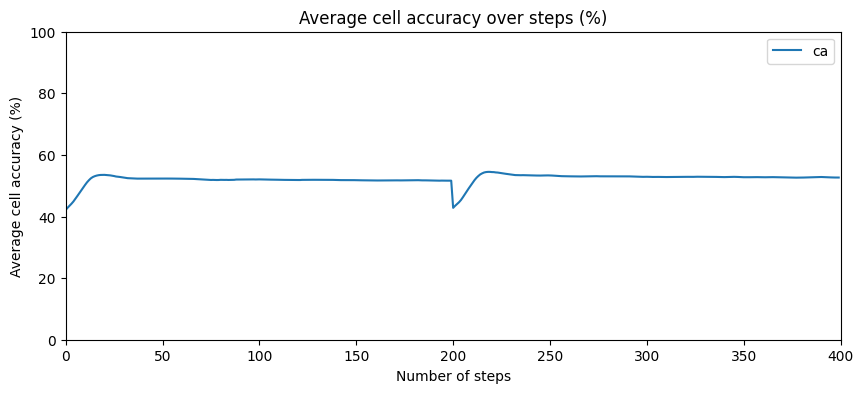

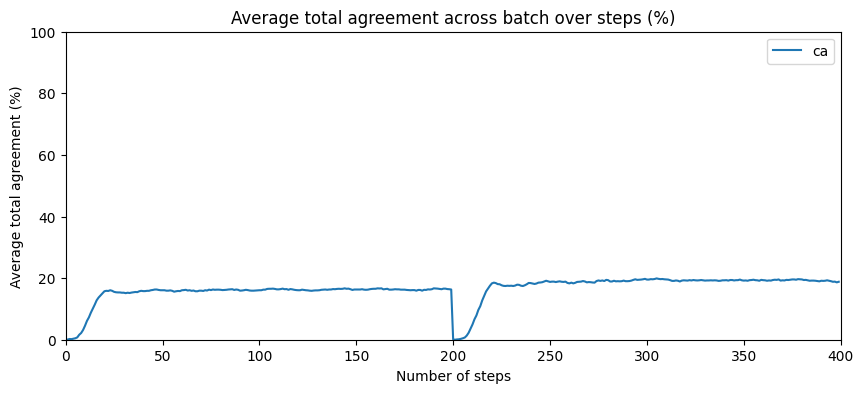

In [60]:
eval_batch = 1000
num_iters = 10

all_accuracies, all_agreements = eval_all(ca, num_steps=200, mutate=True)

pl.figure(figsize=(10, 4))
pl.title('Average cell accuracy over steps (%)')
pl.xlabel('Number of steps')
pl.ylabel('Average cell accuracy (%)')
pl.xlim(0, 400)
pl.ylim(0, 100)
pl.plot(all_accuracies, label="ca")
pl.legend()
pl.show()

pl.figure(figsize=(10, 4))
pl.title('Average total agreement across batch over steps (%)')
pl.xlabel('Number of steps')
pl.ylabel('Average total agreement (%)')
pl.xlim(0, 400)
pl.ylim(0, 100)
pl.plot(all_agreements, label="ca")
pl.legend()
pl.show()

That's quite bad, but we won't worry about that for now!